In [1]:
%load_ext autoreload
# %matplotlib notebook
# %matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../")
import ompy

from scipy.interpolate import interp1d

%autoreload 2
#%load_ext snakeviz

## Testing the Gaussian smoothing

In [2]:
max = int(100)
E_array = np.linspace(0, max, max+1)
bin_width = E_array[1] - E_array[0]
def do_smoothing(smoother):
    
    counts_array = np.zeros(len(E_array))
    counts_array[int(max/2)] = 1
    fwhm = 150*np.ones(len(E_array))
    fwhm_div_E = fwhm/(E_array+bin_width)
    fwhm_div_E[0] = fwhm_div_E[1]

    counts_array_smoothed = smoother(counts_array, E_array, fwhm_div_E)
    for i in range(40):
        counts_array_smoothed = smoother(counts_array_smoothed, E_array, fwhm_div_E)
    return counts_array, counts_array_smoothed

gaussian = ompy.gaussian(E_array+bin_width,mu=50+bin_width, sigma=1)
gaussian /= gaussian.sum()

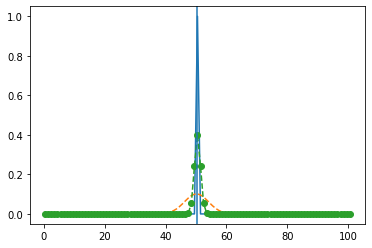

In [3]:
smoother = ompy.gauss_smoothing
counts_array, counts_array_smoothed = do_smoothing(smoother)

f, ax = plt.subplots(1)
ax.plot(E_array+bin_width/2, counts_array)
ax.plot(E_array+bin_width/2, counts_array_smoothed, "--")
ax.plot(E_array+bin_width/2, gaussian, "o--")
ax.axvline(x=E_array[int(max/2)]+bin_width/2)

## Get Response functions

Calibration coefficients: {'a00': -2.5, 'a01': 5.0, 'a10': -2.5, 'a11': 5.0}
E_max =  3992.5


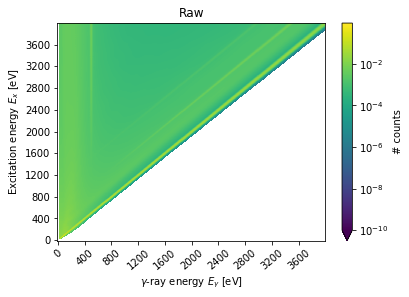

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe3147eb588>)

In [4]:
# Load a response matrix
#fname_resp_mat = "Dy164/data/response_matrix.m"
#fname_resp_mat = "response_matrix_OSCAR_Si28_compressed.m"
# fname_resp_mat = "response_matrix_OSCAR_Si28_compressed.m"
fname_resp_mat = "resp/response_matrix_OSCAR_5keV_viewing.m"
R_mama = ompy.Matrix(path=fname_resp_mat)

zmin_resp = 1e-10 # Plotting

print("Calibration coefficients:", R_mama.calibration())
print("E_max = ", R_mama.Eg.max())

R_mama.plot(scale="log", vmin=zmin_resp)
# plt.colorbar(cbar)

In [5]:
# Then do the same using OMpy functionality:
folderpath = "../../oscar2017_scale1.15"
# TODO port to old NaI: I wrote the original code for Fabio's OSCAR responses. But we need to be able to use the old NaI response functions also.
#folderpath = "/home/jorgenem/gitrepos/oslo-method-software/mama/resp/nai2012"

# Energy calibration of resulting response matrix:
#Eout_array = ompy.E_array_from_calibration(a0=0.525000E+02-112/2, a1=0.112000E+03, E_max=13000)
binwidth=5
Eout_array = ompy.E_array_from_calibration(a0=0, a1=binwidth, E_max=3500)

# Experimental relative FWHM at 1.33 MeV of resulting array (TODO set up default value for this):
FWHM = 2.27 # I think this is the standard in MAMA, TODO double check

#%snakeviz R_ompy, f_FWHM_rel, f_Eff_tot, f_pcmp, f_pFE, f_pSE, f_pDE, f_p511 = ompy.interpolate_response(folderpath, Eout_array, FWHM)
R_ompy = ompy.interpolate_response(folderpath, Eout_array, FWHM)

Note: The response below 200 keV is interpolation only, as there are no simulations available.


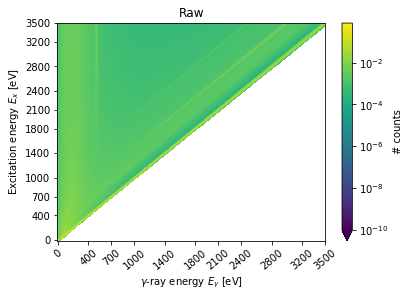

(-5.0, 300)

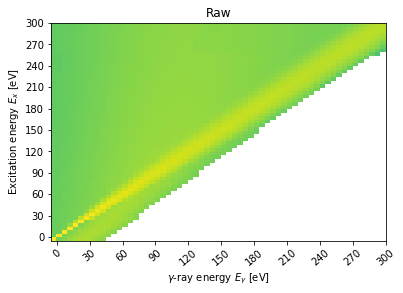

In [6]:
#R_ompy = ompy.Matrix(matrix=R_ompy, E0_array=Eout_array, E1_array=Eout_array)
R_ompy.plot(scale="log", vmin=zmin_resp)

fig, ax = plt.subplots()
R_ompy.plot(scale="log", ax=ax, vmin=zmin_resp)
ax.set_xlim(None, 300)
ax.set_ylim(None, 300)

In [7]:
# Compare projections:
%matplotlib notebook

def plt_compare_mama(E_arr):
    if len(E_arr)!=9:
        raise NotImplementedError("Have to work")
    fig, ax_mat = plt.subplots(3,3, constrained_layout=True,
                          sharex=False, sharey=False,
                          )
    for i, E in enumerate(E_arr):
        ax = ax_mat.flatten()[i]

        E_limits = [E-binwidth/2, E+binwidth/2]

        # MAMA:
        R_mama.plot_projection(axis="Eg", Emin=E_limits[0],
                               Emax=E_limits[1], ax=ax, label="R_mama")

        # ompy:
        R_ompy.plot_projection(axis="Eg", Emin=E_limits[0],
                               Emax=E_limits[1], ax=ax, label="R_ompy")

    #     ax.set_yscale("log")
    #     ax.set_ylim(1e-2,0.5)
        ax.set_xlim(0, E_arr[-1]+200)
        if i==0:
            ax.legend()

        if i<6:
            ax.set_xticklabels([])
        if i%3 != 0:
            ax.set_yticklabels([])
        
        ax.set_ylabel("")

        ax.text(0.5, .5, "{:.0f}+-{:.0f} keV".format(E, binwidth/2),
               transform = ax.transAxes, fontsize=8)
    fig.suptitle('projection of response on x axis ', fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, ax_mat

E_arr = np.linspace(500, 3400, 9)
fig, ax_mat = plt_compare_mama(E_arr)
fig.savefig("resp/response_compare_1.png")

E_arr = np.linspace(50, 500, 9)
fig, ax_mat = plt_compare_mama(E_arr)
fig.savefig("resp/response_compare_2.png")


plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

checking that the full energy peak is created at the correct location

In [8]:
f, ax = plt.subplots(1)

E_sel=200

i_Ex = ompy.i_from_E(E_sel, R_ompy.Ex)
# print("R_ompy.E0_array[i_Ex] =", R_ompy.E0_array[i_Ex])

# ompy:
for i in range(i_Ex-1, i_Ex+2):
    label = "E_in = {:.1f}".format(R_ompy.Ex[i] + R_ompy.calibration()["a01"]/2)
    ax.plot(R_ompy.Ex + R_ompy.calibration()["a01"]/2, 
            R_ompy.values[i, :], 
            marker="o",
            label=label)

ax.axvline(x=E_sel+binwidth/2, label="Eg={}".format(E_sel+binwidth/2))
ax.set_xlim(E_sel-40, E_sel+40)
ax.legend()

plt.show()

<IPython.core.display.Javascript object>

## Comparison to Geant4 simulations (12 July 2019)

In [9]:
# some helper functions to get the correct geant4 spectrum
def fFWHM(E, p):
    # fwhm in keV
    return np.sqrt(p[0] + p[1] * E + p[2]*E**2)

def fFWHM_rel(E, p):
    return fFWHM(E, p) / E

# analysis of Frank
pars = np.array([73.2087, 0.50824, 9.62481e-05])

E_sel=3000
sim_org = np.loadtxt("resp/geant4_3000keV.dat")
# sim_org = np.loadtxt("geant4_600keV.dat")
sim_org[:,0] *= 1000
# smoother(counts_array_smoothed, E_array, fwhm_div_E)
# geant spectrum seems to be in center bin calibration already
# binwidth = sim[:,1] - sim[:,0]
sim =np.copy(sim_org)
fFWHM_rel = fFWHM_rel(sim[:,0],pars)*100
sim[:,1] = ompy.gauss_smoothing(sim_org[:,1], sim_org[:,0], fFWHM_rel)
print("Rel FWHM at 1333 kev: {:.3f}%".format(fFWHM(1333,pars)/1333*100))

Rel FWHM at 1333 kev: 2.278%


In [10]:
def compare():
    # Compare projections:
    f_compare, (ax, ax2) = plt.subplots(2,1, sharex=True)
    f_compare.subplots_adjust(hspace=0)


    # MAMA:
    # R_mama.plot_projection_x(E_limits = E_limits, ax=ax, label="R_mama")
    i_Ex = ompy.i_from_E(E_sel, R_mama.Ex)
    hist_mama = R_mama.values[i_Ex, :]
    bin_width = R_mama.Ex[1] - R_mama.Ex[0]
    hist_mama /= hist_mama.sum()
    hist_mama /= bin_width
    ax.plot(R_mama.Ex+bin_width/2, R_mama.values[i_Ex, :], marker="o",
            markersize=3, label="R_mama")

    # ompy:
    # R_ompy.plot_projection_x(E_limits = E_limits, ax=ax, marker="o", label="R_ompy")
    i_Ex = ompy.i_from_E(E_sel, R_ompy.Ex)
    hist_ompy = R_ompy.values[i_Ex, :]
    bin_width = R_ompy.Ex[1] - R_ompy.Ex[0]
    hist_ompy /= hist_ompy.sum()
    hist_ompy /= bin_width
    ax.plot(R_ompy.Ex+bin_width/2, R_ompy.values[i_Ex, :], marker="o",
            markersize=3, label="R_ompy")

    spec = sim
    sim_normed = spec[:,1] / spec[:,1].sum()
    bin_width = sim[1,0]-sim[0,0]
    sim_normed /= bin_width
    ax.plot(sim[:,0], sim_normed, label="R_Geant (smoothed with FWHM)")

    ax.legend()
    ax.set_title("Comarison of generated resonses with Mama/Ompy vs directly Geant4"
                 "\nfor E_in {:.1f} keV".format(E_sel))
    ax.set_ylabel("Probability")
    ax2.set_ylabel("Ratio")
    ax.set_xlabel("Eg (keV)")

    ax.set_yscale("log")
    ax.set_xlim(0,E_sel+50)
    ax.set_ylim(5e-5,7e-3)

    ######

    fmama = interp1d(R_mama.Ex, hist_mama)
    fompy = interp1d(R_ompy.Ex, hist_ompy)

    # fig, ax = plt.subplots()
    idx = np.abs(sim[:,0]-(E_sel+50)).argmin()
    ax2.plot(sim[:idx,0],fmama(sim[:idx,0]) / sim_normed[:idx], label="mama / geant")
    ax2.plot(sim[:idx,0],fompy(sim[:idx,0]) / sim_normed[:idx], label="ompy / geant")

    ax2.set_ylim(0.5,1.8)
    # ax2.set_xlim(0,E_sel+300)
    ax2.legend()


    # f_compare.show()
    plt.savefig("resp/resp_{:d}.png".format(E_sel))
plt.show()



So we receive a quite good match!
The main difference is in the heigh of the 511 peak; however, this because we use a (slightly) 
different/updated FHWM function for the smoothing of the geant4 results. Should be updated in 
ompy afterwards, too (so the response funciton files it reads)

<IPython.core.display.Javascript object>


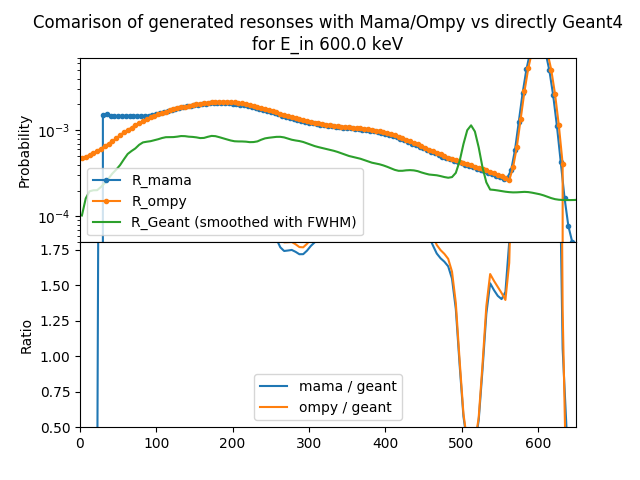

In [12]:
E_sel=600
sim_org = np.loadtxt("resp/geant4_3000keV.dat")
# sim_org = np.loadtxt("geant4_600keV.dat")
sim_org[:,0] *= 1000
# smoother(counts_array_smoothed, E_array, fwhm_div_E)
# geant spectrum seems to be in center bin calibration already
# binwidth = sim[:,1] - sim[:,0]
sim =np.copy(sim_org)
# fFWHM_rel = fFWHM_rel(sim[:,0],pars)*100
sim[:,1] = ompy.gauss_smoothing(sim_org[:,1], sim_org[:,0], fFWHM_rel)
# print("Rel FWHM at 1333 kev: {:.3f}%".format(fFWHM(1333,pars)/1333*100))

compare()